In [ ]:
import numpy as np
import pandas as pd
import os, sys
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score
from sklearn.decomposition import PCA


In [ ]:
# Reading Data and obtaining features and lables
df=pd.read_csv('parkinsons.data')
df.head()

features=df.loc[:,df.columns!='status'].values[:,1:]

labels=df.loc[:,'status'].values

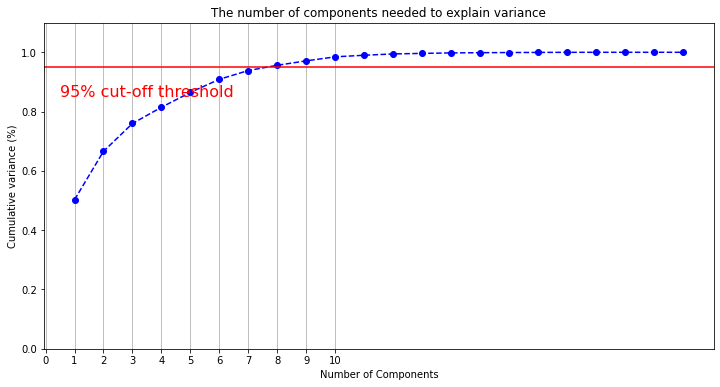

In [ ]:
# PCA (to find the best n_components using 95% variance)

scaler = MinMaxScaler()
features_rescaled = scaler.fit_transform(features)

# Finding number of n_components required

pca = PCA().fit(features_rescaled)

plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 23, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 11, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

# n_components = 8 for 95% variance

pca = PCA(n_components = 8)
pca.fit(features_rescaled)
reduced_features = pca.transform(features_rescaled)

In [ ]:
# SVM Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Data
x = reduced_features;
y = labels
x_train,x_test,y_train,y_test=train_test_split(x, y, test_size=0.25, random_state=10)

# Define the parameter grid
param_grid = {'C': [0.1, 1, 10],
              'gamma': [1, 0.1, 0.01, 0.001],
              'degree': [2, 3, 4, 5],
              'kernel': ['linear', 'rbf', 'poly', 'sigmoid']}

# Create a grid search object
grid_search = GridSearchCV(SVC(), param_grid, refit=True, cv=10)
# Fit the grid search object to the data
grid_search.fit(x_train, y_train)

# Print the best parameters and the best score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)
print("Best estimator: ", grid_search.best_estimator_)

grid_predictions = grid_search.predict(x_test)
print(classification_report(y_test, grid_predictions))


Best parameters:  {'C': 10, 'degree': 2, 'gamma': 1, 'kernel': 'rbf'}
Best score:  0.9114285714285714
Best estimator:  SVC(C=10, degree=2, gamma=1)
              precision    recall  f1-score   support

           0       0.92      0.85      0.88        13
           1       0.95      0.97      0.96        36

    accuracy                           0.94        49
   macro avg       0.93      0.91      0.92        49
weighted avg       0.94      0.94      0.94        49



In [ ]:
# SVC with RBF (Params with GridSearchCV) with best parameters after PCA
from sklearn import svm
clf = svm.SVC(C = 10, kernel ='rbf', gamma = 1)
x=reduced_features
y=labels
x_train,x_test,y_train,y_test=train_test_split(x, y, test_size=0.25, random_state=7)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
print("Accuracy score is: ", accuracy_score(y_test, y_pred))
print("F1 score is: ", f1_score(y_test, y_pred))
print("Precision score is: ", precision_score(y_test, y_pred))
print("Recall score is: ", recall_score(y_test, y_pred))
print("ROC AUC score is: ", roc_auc_score(y_test, y_pred))
print("Confusion Matrix")
pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    columns=['Predicted Healthy', 'Predicted Parkinsons'],
    index=['True Healthy', 'True Parkinsons']
)


Accuracy score is:  0.9591836734693877
F1 score is:  0.975
Precision score is:  0.9512195121951219
Recall score is:  1.0
ROC AUC score is:  0.9
Confusion Matrix


,Predicted Healthy,Predicted Parkinsons
True Healthy,8,2
True Parkinsons,0,39


In [ ]:
# MLP Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier

mlp_clf = MLPClassifier(max_iter=500)

# Data
x = reduced_features;
y = labels
x_train,x_test,y_train,y_test=train_test_split(x, y, test_size=0.25, random_state=7)

# Define the parameter grid
param_grid = {
    'hidden_layer_sizes': [(50,), (50,50), (150,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant','adaptive'],
}

# Create a grid search object
grid_search = GridSearchCV(mlp_clf, param_grid, n_jobs=-1, cv=5)
# Fit the grid search object to the data
grid_search.fit(x_train, y_train)

# Print the best parameters and the best score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)
print("Best estimator: ", grid_search.best_estimator_)

grid_predictions = grid_search.predict(x_test)
print(classification_report(y_test, grid_predictions))


Best parameters:  {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'solver': 'adam'}
Best score:  0.8701149425287357
Best estimator:  MLPClassifier(alpha=0.001, hidden_layer_sizes=(50, 50), max_iter=500)
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       0.97      1.00      0.99        39

    accuracy                           0.98        49
   macro avg       0.99      0.95      0.97        49
weighted avg       0.98      0.98      0.98        49



/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(activation= 'relu', alpha= 0.001, hidden_layer_sizes= (50,50), learning_rate= 'constant', solver= 'adam', max_iter=250, random_state=42)
x = reduced_features
y = labels
x_train,x_test,y_train,y_test=train_test_split(x, y, test_size=0.25, random_state=7)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
print("Accuracy score is: ", accuracy_score(y_test, y_pred))
print("F1 score is: ", f1_score(y_test, y_pred))
print("Precision score is: ", precision_score(y_test, y_pred))
print("Recall score is: ", recall_score(y_test, y_pred))
print("ROC AUC score is: ", roc_auc_score(y_test, y_pred))
print("Confusion Matrix")
pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    columns=['Predicted Healthy', 'Predicted Parkinsons'],
    index=['True Healthy', 'True Parkinsons']
)

Accuracy score is:  0.9183673469387755
F1 score is:  0.951219512195122
Precision score is:  0.9069767441860465
Recall score is:  1.0
ROC AUC score is:  0.8
Confusion Matrix


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


,Predicted Healthy,Predicted Parkinsons
True Healthy,6,4
True Parkinsons,0,39


In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=7)
x = features_rescaled
y = labels
x_train,x_test,y_train,y_test=train_test_split(x, y, test_size=0.25, random_state=7)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
print("Accuracy score is: ", accuracy_score(y_test, y_pred))
print("F1 score is: ", f1_score(y_test, y_pred))
print("Precision score is: ", precision_score(y_test, y_pred))
print("Recall score is: ", recall_score(y_test, y_pred))
print("Confusion Matrix")
pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    columns=['Predicted Healthy', 'Predicted Parkinsons'],
    index=['True Healthy', 'True Parkinsons']
)

Accuracy score is:  0.8367346938775511
F1 score is:  0.9024390243902439
Precision score is:  0.8604651162790697
Recall score is:  0.9487179487179487
Confusion Matrix


,Predicted Healthy,Predicted Parkinsons
True Healthy,4,6
True Parkinsons,2,37


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=5)
x = reduced_features
y = labels
x_train,x_test,y_train,y_test=train_test_split(x, y, test_size=0.2, random_state=7)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
print("Accuracy score is: ", accuracy_score(y_test, y_pred))
print("F1 score is: ", f1_score(y_test, y_pred))
print("Precision score is: ", precision_score(y_test, y_pred))
print("Recall score is: ", recall_score(y_test, y_pred))
print("ROC AUC score is: ", roc_auc_score(y_test, y_pred))
print("Confusion Matrix")
pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    columns=['Predicted Healthy', 'Predicted Parkinsons'],
    index=['True Healthy', 'True Parkinsons']
)

Accuracy score is:  0.9743589743589743
F1 score is:  0.9846153846153847
Precision score is:  0.9696969696969697
Recall score is:  1.0
ROC AUC score is:  0.9285714285714286
Confusion Matrix


,Predicted Healthy,Predicted Parkinsons
True Healthy,6,1
True Parkinsons,0,32


In [ ]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=10, criterion="log_loss", max_depth=5)
x = reduced_features
y = labels
x_train,x_test,y_train,y_test=train_test_split(x, y, test_size=0.25, random_state=10)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
print("Accuracy score is: ", accuracy_score(y_test, y_pred))
print("F1 score is: ", f1_score(y_test, y_pred))
print("Precision score is: ", precision_score(y_test, y_pred))
print("Recall score is: ", recall_score(y_test, y_pred))
print("ROC AUC score is: ", roc_auc_score(y_test, y_pred))
print("Confusion Matrix")
pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    columns=['Predicted Healthy', 'Predicted Parkinsons'],
    index=['True Healthy', 'True Parkinsons']
)

Accuracy score is:  0.8775510204081632
F1 score is:  0.9210526315789473
Precision score is:  0.875
Recall score is:  0.9722222222222222
ROC AUC score is:  0.7938034188034189
Confusion Matrix


,Predicted Healthy,Predicted Parkinsons
True Healthy,8,5
True Parkinsons,1,35


In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=7, criterion="log_loss", max_depth=5)
x = features_rescaled
y = labels
x_train,x_test,y_train,y_test=train_test_split(x, y, test_size=0.25, random_state=7)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
print("Accuracy score is: ", accuracy_score(y_test, y_pred))
print("F1 score is: ", f1_score(y_test, y_pred))
print("Precision score is: ", precision_score(y_test, y_pred))
print("Recall score is: ", recall_score(y_test, y_pred))
print("ROC AUC score is: ", roc_auc_score(y_test, y_pred))
print("Confusion Matrix")
pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    columns=['Predicted Healthy', 'Predicted Parkinsons'],
    index=['True Healthy', 'True Parkinsons']
)

Accuracy score is:  0.9183673469387755
F1 score is:  0.9500000000000001
Precision score is:  0.926829268292683
Recall score is:  0.9743589743589743
ROC AUC score is:  0.8371794871794871
Confusion Matrix


,Predicted Healthy,Predicted Parkinsons
True Healthy,7,3
True Parkinsons,1,38


In [ ]:
# Testing and preventing overfitting

from sklearn import svm

x=reduced_features
y=labels


x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=10)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=40)


print("Validation Accuracy")
for c in [0.1, 1, 10, 100]:
  for g in [1, 0.1, 0.01]:
    clf = svm.SVC(C = c, kernel ='rbf', gamma = g)
    clf.fit(x_train, y_train)
    y_val_pred = clf.predict(x_val)
    print("Accuracy score is: (C: " + str(c) +", g: " + str(g) +") " , accuracy_score(y_val, y_val_pred))

print("Test Accuracy")
for c in [0.1, 1, 10, 100]:
  for g in [1, 0.1, 0.01]:
    clf = svm.SVC(C = c, kernel ='rbf', gamma = g)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    print("Accuracy score is: (C: " + str(c) +", g: " + str(g) +") " , accuracy_score(y_test, y_pred))

Validation Accuracy
Accuracy score is: (C: 0.1, g: 1)  0.717948717948718
Accuracy score is: (C: 0.1, g: 0.1)  0.717948717948718
Accuracy score is: (C: 0.1, g: 0.01)  0.717948717948718
Accuracy score is: (C: 1, g: 1)  0.8717948717948718
Accuracy score is: (C: 1, g: 0.1)  0.7435897435897436
Accuracy score is: (C: 1, g: 0.01)  0.717948717948718
Accuracy score is: (C: 10, g: 1)  1.0
Accuracy score is: (C: 10, g: 0.1)  0.8974358974358975
Accuracy score is: (C: 10, g: 0.01)  0.7435897435897436
Accuracy score is: (C: 100, g: 1)  0.9743589743589743
Accuracy score is: (C: 100, g: 0.1)  0.9487179487179487
Accuracy score is: (C: 100, g: 0.01)  0.9230769230769231
Test Accuracy
Accuracy score is: (C: 0.1, g: 1)  0.8125
Accuracy score is: (C: 0.1, g: 0.1)  0.8125
Accuracy score is: (C: 0.1, g: 0.01)  0.8125
Accuracy score is: (C: 1, g: 1)  0.90625
Accuracy score is: (C: 1, g: 0.1)  0.8125
Accuracy score is: (C: 1, g: 0.01)  0.8125
Accuracy score is: (C: 10, g: 1)  0.96875
Accuracy score is: (C: 10, 